# Importacion de librerias

## Exploración de datos y visualización

In [59]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

## Manejo de Rasters

In [60]:
import rasterio as rio
import matplotlib.patches as mpatches
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image
from tqdm import tqdm
from pyproj import Proj, transform
from shapely.geometry import Polygon
from osgeo import gdal, ogr, osr

In [61]:
import tensorflow as tf
from tensorflow.python.client import device_lib

2023-10-05 10:25:45.491201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 10:25:45.888148: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 10:25:46.741692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/theend/miniconda3/envs/soil-env/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/theend/miniconda3/envs/soil-env/lib/:/usr/local/cuda-11.8/lib64:
2023-10-05 10:25:46.741769: W tensorflow/stream_executor/p

# Utilidades

### Establecer semilla aleatoria para la reproductibilidad

In [62]:
# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
random.seed(RANDOM_SEED)

# Set random state for NumPy
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [63]:
def print_info():
    tf_version = tf.__version__
    gpus = [x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    cuda_version = tf.sysconfig.get_build_info()['cuda_version']
    cudnn_version = tf.sysconfig.get_build_info()['cudnn_version']
    
    print('Versión de TensorFlow: {}'.format(tf_version))
    print('GPU: {}'.format(gpus))
    print('Versión Cuda: {}'.format(cuda_version))
    print('Versión Cudnn: {}\n'.format(cudnn_version))

print_info()

Versión de TensorFlow: 2.10.1
GPU: ['device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6']
Versión Cuda: 11.2
Versión Cudnn: 8



2023-10-05 10:25:47.851105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 10:25:49.064530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:25:49.177342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 10:25:49.177517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Diccionario de todas las clases e identificadores de clase

In [64]:
class_names = dict((
    (0, 'Sin Clasificar'),
    (1, 'Bosque'),
    (2, 'Cuerpo de Agua'),
    (3, 'Otras Tierras'),
    (4, 'Tierra Agropecuaria'),
    (5, 'Vegetacion Arbustiva y Herbacea'),
    (6, 'Zona Antropica'),
))

In [65]:
colors_class = dict((
    (0, (0, 0, 0)),         # Background
    (1, (62, 178, 49)),     # Arboles
    (2, (0, 0, 251)),       # Water
    (3, (122, 125, 74)),    # Otras Tierras (Sin cobertura vegetal)
    (4, (245, 106, 0)),     # Tierra Agropecuaria
    (5, (255, 165, 81)),    # Vegetacion Arbustiva y Herbacea
    (6, (255, 0, 0)),       # Area Construida
))

In [66]:
reclassification = {
    255: 0      # Change 255 to 0
}

### Fusionar las clases NLCD en un subconjunto más manejable.

In [67]:
def merge_classes(y):
    if reclassification is None:
        return []

    if not isinstance(reclassification, dict):
        raise TypeError("Reclassification must be a dictionary.")

    for index, item in reclassification.items():
        y[y == index] = item

    return y

# Configuracion de directiorios de los mosaicos

In [68]:
label_path = '../data/images/processed/labels/landsat/landcover_ecuador_v1.tif'
rasters_path = '../data/images/processed/products/landsat/LC08_L1TP_010063_20130808_20200912_02_T1_M.tif'

# Preprocesamiento de clases NLCD

In [69]:
import sys
sys.path.append('../')
from src.controllers.raster import RasterController
from src.controllers.pixel import PixelController
from src.layers.dict_class import LandCoverClassDict
from src.layers.utilities import samples_by_class

# Procesamiento de la imagen de etiquetas NLDC

In [70]:
raster = RasterController()

In [71]:
dataset_labels = raster.open_raster(raster=label_path)

Number of bands in the image: 1

Image size: 25540 rows x 34000 columns

Raster driver: GTiff

Image projection:
 EPSG:32717



## Lectura de mosaico

In [72]:
labels_image = raster.read_raster(dataset_labels)
labels_image.shape

(1, 25540, 34000)

In [73]:
show(labels_image)

KeyboardInterrupt: 

### Total de clases originales NLDC

In [ ]:
data_list = samples_by_class(labels_image, class_names)
data_list

[('Sin Clasificar', 511054838),
 ('Bosque', 181339750),
 ('Cuerpo de Agua', 7058888),
 ('Otras Tierras', 1558991),
 ('Tierra Agropecuaria', 129146919),
 ('Vegetacion Arbustiva y Herbacea', 34098007),
 ('Zona Antropica', 4102607)]

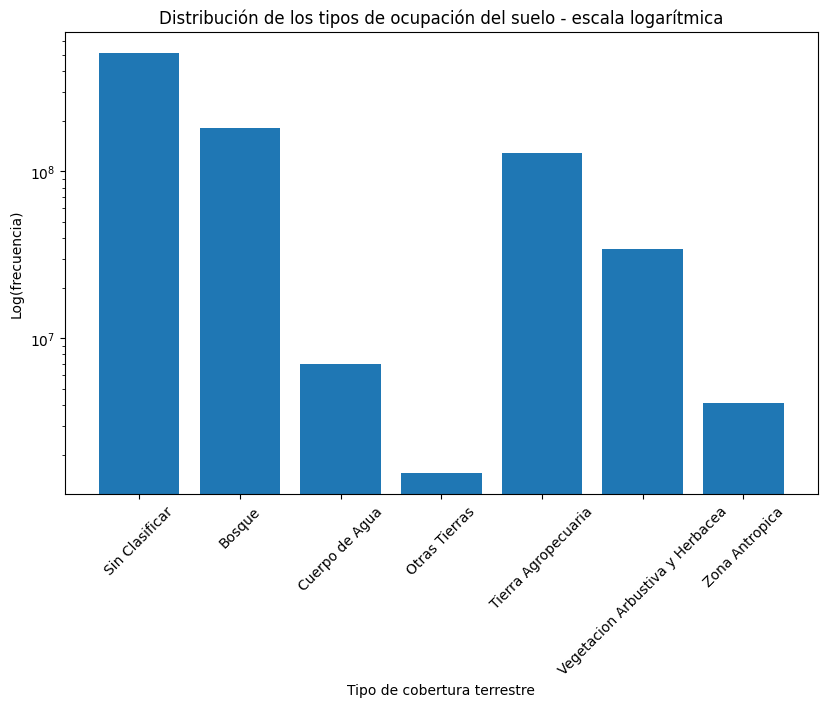

In [ ]:
fig = plt.figure(figsize=(1.62*6, 6)) 
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Tipo de cobertura terrestre")
plt.ylabel("Log(frecuencia)")
plt.title("Distribución de los tipos de ocupación del suelo - escala logarítmica")
_ = plt.bar([classe[0] for classe in data_list], [classe[1] for classe in data_list])

### Proporcion de muestras por clases originales

In [ ]:
unique, counts = np.unique(labels_image, return_counts=True)
unique, counts = unique[1:], counts[1:]  # skip 0
prop_list = []
for ii, jj in enumerate(unique):
    prop_list.append(counts[ii]/np.sum(counts))
    print(str(class_names[jj]+': '), '{:.2f}'.format(counts[ii]/np.sum(counts)))

Bosque:  0.51
Cuerpo de Agua:  0.02
Otras Tierras:  0.00
Tierra Agropecuaria:  0.36
Vegetacion Arbustiva y Herbacea:  0.10
Zona Antropica:  0.01


## Mezclar clases cobertura terrestre

In [ ]:
images_merge = merge_classes(labels_image)
images_merge.shape

(1, 25540, 34000)

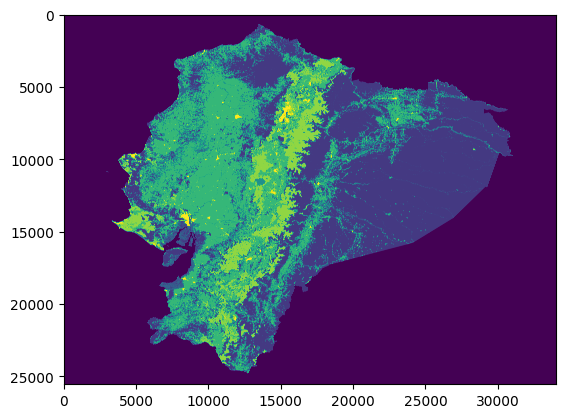

<Axes: >

In [ ]:
show(images_merge)

### Total de clases mezcladas NLDC

In [ ]:
unique, counts = np.unique(images_merge, return_counts=True)
data_listm = [(class_names[x], counts) for x, counts in list(zip(unique, counts))]
data_listm

[('Sin Clasificar', 511054838),
 ('Bosque', 181339750),
 ('Cuerpo de Agua', 7058888),
 ('Otras Tierras', 1558991),
 ('Tierra Agropecuaria', 129146919),
 ('Vegetacion Arbustiva y Herbacea', 34098007),
 ('Zona Antropica', 4102607)]

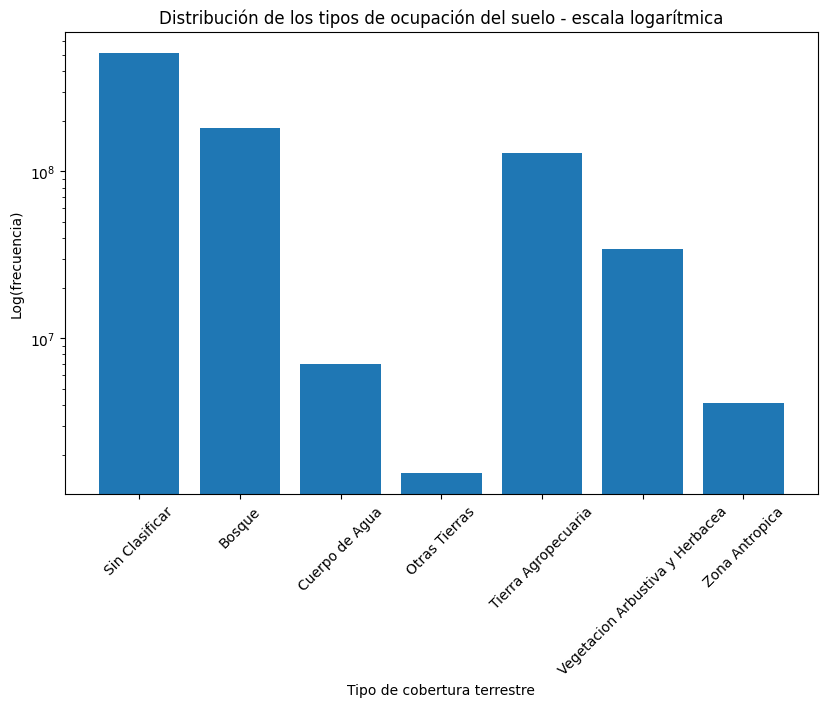

In [ ]:
fig = plt.figure(figsize=(1.62*6, 6))
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Tipo de cobertura terrestre")
plt.ylabel("Log(frecuencia)")
plt.title("Distribución de los tipos de ocupación del suelo - escala logarítmica")
_ = plt.bar([classe[0] for classe in data_listm], [classe[1] for classe in data_listm])

### Proporcion de muestras por clases mezcladas

In [ ]:
unique, counts = np.unique(images_merge, return_counts=True)
unique, counts = unique[1:], counts[1:]  # skip 0
prop_list = []
for ii, jj in enumerate(unique):
    prop_list.append(counts[ii]/np.sum(counts))
    print(str(class_names[jj]+': '),'{:.2f}'.format(counts[ii]/np.sum(counts)))

Bosque:  0.51
Cuerpo de Agua:  0.02
Otras Tierras:  0.00
Tierra Agropecuaria:  0.36
Vegetacion Arbustiva y Herbacea:  0.10
Zona Antropica:  0.01


### Visualizar clases mezcladas

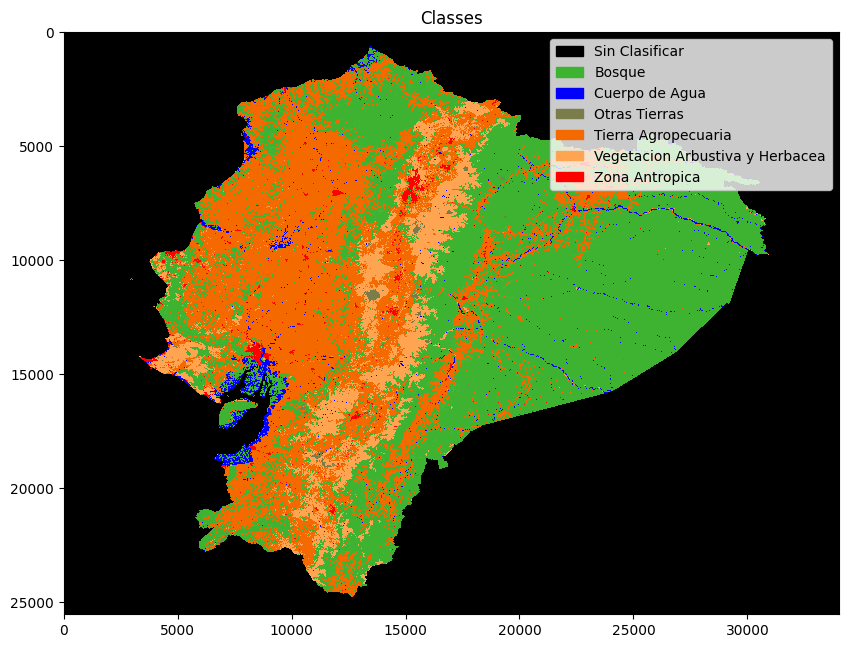

In [ ]:
n = int(np.max(images_merge)) + 1

# Put 0 - 255 as float 0 - 1
for k in colors_class:
    v = colors_class[k]
    _v = [_v / 255.0 for _v in v]
    colors_class[k] = _v

index_false_colors = [colors_class[key] for key in range(0, n)]

cmap_false_colors = plt.matplotlib.colors.ListedColormap(
    index_false_colors, 'Classification', n)

patches = [mpatches.Patch(color=cmap_false_colors.colors[class_id], label=class_names[class_id])
           for class_id in range(len(cmap_false_colors.colors))]

fig, axs = plt.subplots(figsize=(10, 10))

# location of training pixels on the image
_ = axs.imshow(labels_image[0, :, :],
               cmap=cmap_false_colors,
               interpolation='none')
axs.legend(handles=patches)
axs.set_title('Classes')

plt.show()

# Preprocesamiento del mosaico de estudio  

In [ ]:
path_rasters = '../data/images/processed/products/landsat/toa/'
rasters =  [rio.open(f'{path_rasters}/{raster}') for raster in os.listdir(path_rasters)]

In [ ]:
def gen_balanced_pixel_locations(image_datasets, train_count, label_dataset, merge=False):
    # this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    # and returns a list of training pixel locations and image indices
    # and a list of validation pixel locations and indices

    label_proj = Proj(label_dataset.crs)
    train_pixels = []

    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    print("train_count_per_dataset:", train_count_per_dataset)
    for index, image_dataset in enumerate(image_datasets):
        # how many points from each class
        points_per_class = train_count_per_dataset // len(np.unique(merge_classes(labels_image)))
        print("points_per_class:", points_per_class)
        # get landsat boundaries in this image
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (
            image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)
        print("raster_points:", raster_points)
        l8_proj = Proj(image_dataset.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x, y in raster_points:
            x, y = transform(l8_proj, label_proj, x, y)
            # convert from crs into row, col in label image coords
            row, col = label_dataset.index(x, y)
            # don't forget row, col is actually y, x so need to swap it when we append
            new_raster_points.append((col, row))
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)
        # Window.from_slices((row_start, row_stop), (col_start, col_stop))
        masked_label_image = label_dataset.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(
            raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
        if merge:
            masked_label_image = merge_classes(masked_label_image)
        # loop for each class
        all_points_per_image = []
        # for cls in np.unique(merge_classes(labels_image)):
        progression_bar = tqdm(np.unique(merge_classes(labels_image)))
        for cls in (progression_bar):
            progression_bar.set_description("Processing « %s »" % str(class_names[int(cls)]))
            cls = int(cls)
            # mask the label subset image to each class
            # pull out the indicies where the mask is true
            rows, cols = np.where(masked_label_image[0] == cls)
            all_locations = list(zip(rows, cols))
            # shuffle all locations
            random.shuffle(all_locations)
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            if len(all_locations) != 0:
                for r, c in all_locations[:points_per_class]:
                    # convert label row and col into label geographic space
                    x, y = label_dataset.xy(
                        r+raster_poly.bounds[1], c+raster_poly.bounds[0])
                    # go from label projection into landsat projection
                    x, y = transform(label_proj, l8_proj, x, y)
                    # convert from landsat geographic space into row col
                    r, c = image_dataset.index(x, y)
                    l8_points.append((r, c))
                all_points_per_image += l8_points

        dataset_index_list = [index] * len(all_points_per_image)
        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        train_pixels += dataset_pixels

    random.shuffle(train_pixels)
    return (train_pixels)

print('gen_balanced_pixel_locations code ready!')

gen_balanced_pixel_locations code ready!


# Generar datos de entrenamiento balanceados

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_pixels = gen_balanced_pixel_locations(
    rasters[0:6],
    train_count=15000,
    label_dataset=dataset_labels,
    merge=True
)

train_count_per_dataset: 2500
points_per_class: 357
raster_points: ((561885.0, -368115.0), (711585.0, -368115.0), (711585.0, -524265.0), (561885.0, -524265.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [00:35<00:00,  5.08s/it]                 


points_per_class: 357
raster_points: ((562485.0, -368115.0), (711585.0, -368115.0), (711585.0, -524265.0), (562485.0, -524265.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [00:34<00:00,  4.99s/it]                 


points_per_class: 357
raster_points: ((562785.0, -368115.0), (711585.0, -368115.0), (711585.0, -524265.0), (562785.0, -524265.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [00:35<00:00,  5.04s/it]                 


points_per_class: 357
raster_points: ((565185.0, -368115.0), (711585.0, -368115.0), (711585.0, -524265.0), (565185.0, -524265.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [00:35<00:00,  5.09s/it]                 


points_per_class: 357
raster_points: ((563085.0, -368115.0), (711585.0, -368115.0), (711585.0, -524265.0), (563085.0, -524265.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [00:36<00:00,  5.16s/it]                 


points_per_class: 357
raster_points: ((562785.0, -368115.0), (711585.0, -368115.0), (711585.0, -524265.0), (562785.0, -524265.0))


Processing « Zona Antropica »: 100%|██████████| 7/7 [00:35<00:00,  5.06s/it]                 


##  Comprobación de datos
Conjunto de datos equilibrado y correcto. 
Ubicación real de los píxeles.

In [ ]:
landsat_datasets = rasters[0:6]
# generate the training and validation pixel locations
all_labels = []
label_locations = []
progression_bar = tqdm(train_pixels)
for index, pixel in enumerate(progression_bar):
    progression_bar.set_description("Processing data point: %s" % str(index))

    # row, col location in landsat
    r, c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(dataset_labels.crs)

    # localización geográfica
    x, y = landsat_datasets[ds_index].xy(r, c)
    # pasar de la proyección label a la proyección del mosaico
    x, y = transform(l8_proj, label_proj, x, y)
    # obtener la posición de fila y columna en la etiqueta
    r, c = dataset_labels.index(x, y)

    label_locations.append([r, c])

    # formato (bandas, altura, anchura)
    window = ((r, r+1), (c, c+1))
    data = merge_classes(dataset_labels.read(1, window=window, masked=False, boundless=True))
    all_labels.append(data[0, 0])

label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
points = [(class_names[x], counts) for x, counts in list(zip(unique, counts))]
points

Processing data point: 14993: 100%|██████████| 14994/14994 [02:40<00:00, 93.55it/s]


[('Sin Clasificar', 2146),
 ('Bosque', 2165),
 ('Cuerpo de Agua', 2118),
 ('Otras Tierras', 2110),
 ('Tierra Agropecuaria', 2204),
 ('Vegetacion Arbustiva y Herbacea', 2152),
 ('Zona Antropica', 2099)]

## Visualización de la ubicación de los datos
Muestre ahora el mapa de clases junto a la ubicación de los píxeles de entrenamiento en la imagen

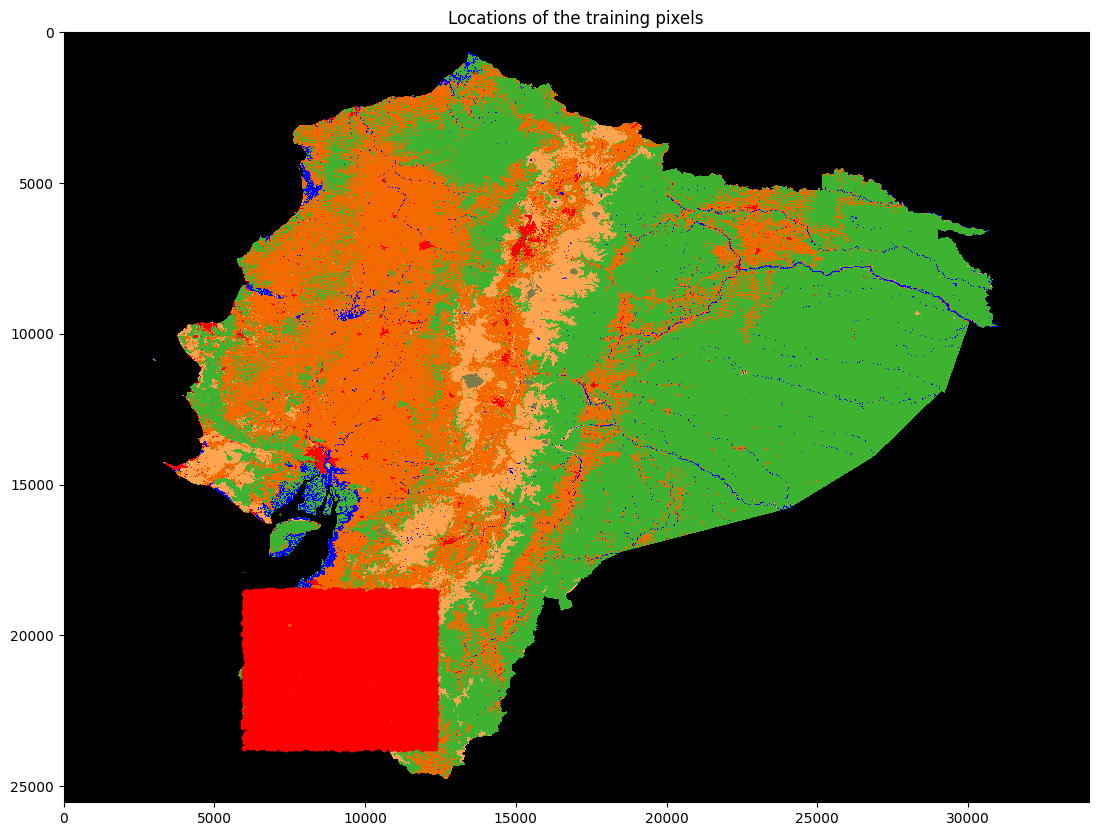

In [ ]:
fig, axs = plt.subplots(figsize=(1.62*10, 10))

# location of training pixels on the image
_ = axs.imshow(labels_image[0, :, :],
               cmap=cmap_false_colors,
               interpolation='none')
axs.scatter(label_locations[:, 1], label_locations[:, 0], s=10, c='r')
axs.set_title("Locations of the training pixels")
plt.show()

In [ ]:
def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    # this is a keras compatible data generator which generates data and labels on the fly
    # from a set of pixel locations, a list of image datasets, and a label dataset

    c = r = 0
    i = 0

    label_proj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)

    while True:
        # take one off because we don't want the QA band
        image_batch = np.zeros(
            (batch_size, tile_height, tile_width, band_count-1))
        label_batch = np.zeros((batch_size, class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i = 0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(
                1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0:  # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile:
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                # print('wrong shape')
                # print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7, :, :], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                # print('Found some cloud.')
                # print(tile[7,:,:])
                pass
            else:
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile) - 982.5) / 1076.5

                # get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    x, y = transform(l8_proj, label_proj, x, y)

                # reference gps in label_image
                row, col = label_dataset.index(x, y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = merge_classes(label_dataset.read(
                    1, window=window, masked=False, boundless=True))
                label = data[0, 0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)

print('tile_generator code ready!')

tile_generator code ready!


## Probando el generador de datos

In [ ]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, dataset_labels, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----


### Visualización de los mosaicos

Ahora vamos a visualizar los azulejos reales. Tenga en cuenta que se verán poco naturales porque han sido normalizados.

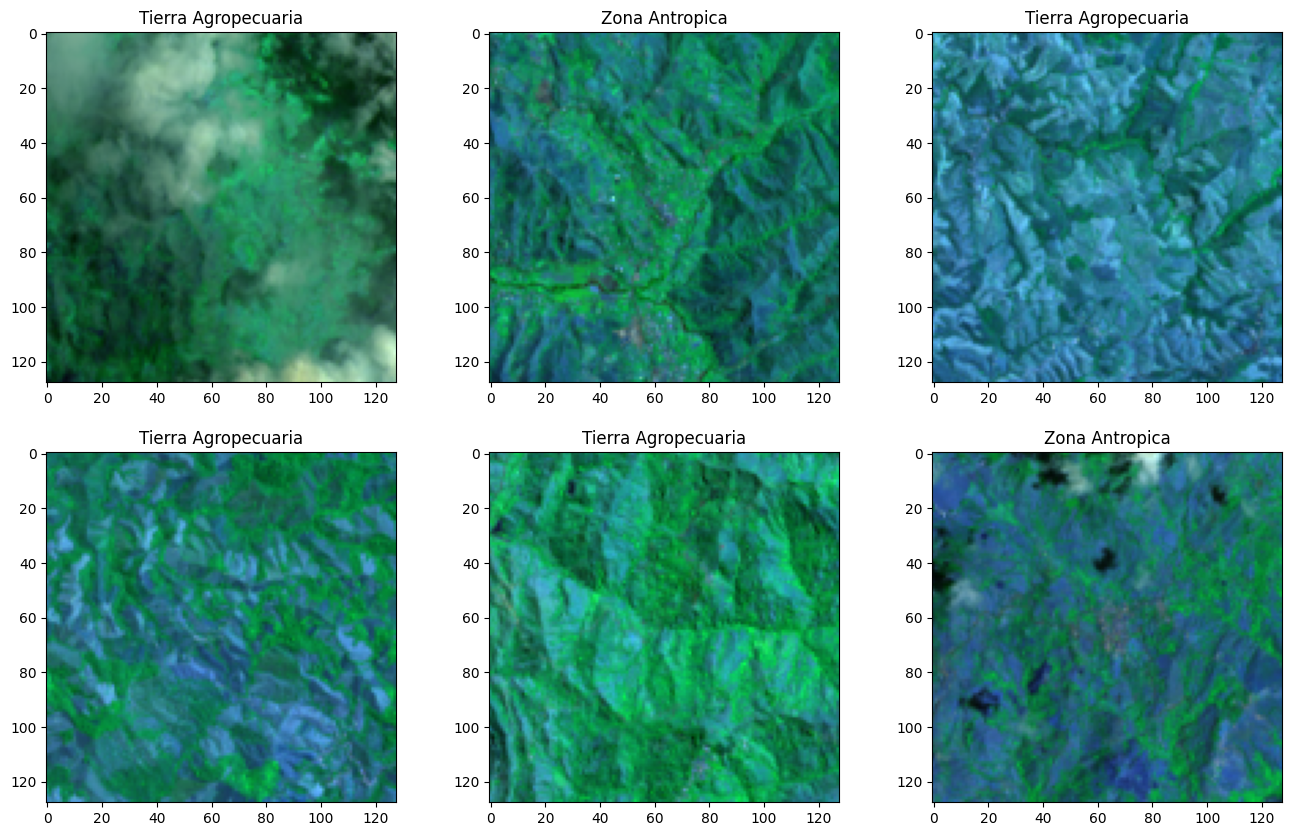

In [ ]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))


fig, axes = plt.subplots(2, 3, figsize=(1.62*10, 10))
axes[0, 0].imshow(normalize(im_batch[0, :, :, 3:6]))
axes[0, 0].set_title(class_names[np.argmax(label_batch[0])])

axes[0, 1].imshow(normalize(im_batch[1, :, :, 3:6]))
axes[0, 1].set_title(class_names[np.argmax(label_batch[1])])

axes[0, 2].imshow(normalize(im_batch[2, :, :, 3:6]))
axes[0, 2].set_title(class_names[np.argmax(label_batch[2])])

axes[1, 0].imshow(normalize(im_batch[3, :, :, 3:6]))
axes[1, 0].set_title(class_names[np.argmax(label_batch[3])])

axes[1, 1].imshow(normalize(im_batch[4, :, :, 3:6]))
axes[1, 1].set_title(class_names[np.argmax(label_batch[4])])

axes[1, 2].imshow(normalize(im_batch[5, :, :, 3:6]))
axes[1, 2].set_title(class_names[np.argmax(label_batch[5])])

plt.show()

## Generar conjunto de datos de entrenamiento de 1x1 azulejos para scikit-learn para visualizar los datos

In [ ]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, dataset_labels, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 7)
----


### Redimencionar 
Remodelar porque scikit-learn necesita datos en formato `(muestras, bandas)`:

In [ ]:
im_batch[0, :, :, :]

array([[[-0.9125424 , -0.91254473, -0.91253287, -0.91249031,
         -0.91234291, -0.91230476, -0.91243643]]])

In [ ]:
im_batch_reshaped = im_batch.reshape(sample_size, 7)
im_batch_reshaped[0]

array([-0.9125424 , -0.91254473, -0.91253287, -0.91249031, -0.91234291,
       -0.91230476, -0.91243643])

## Visualizar Firmas Espectrales

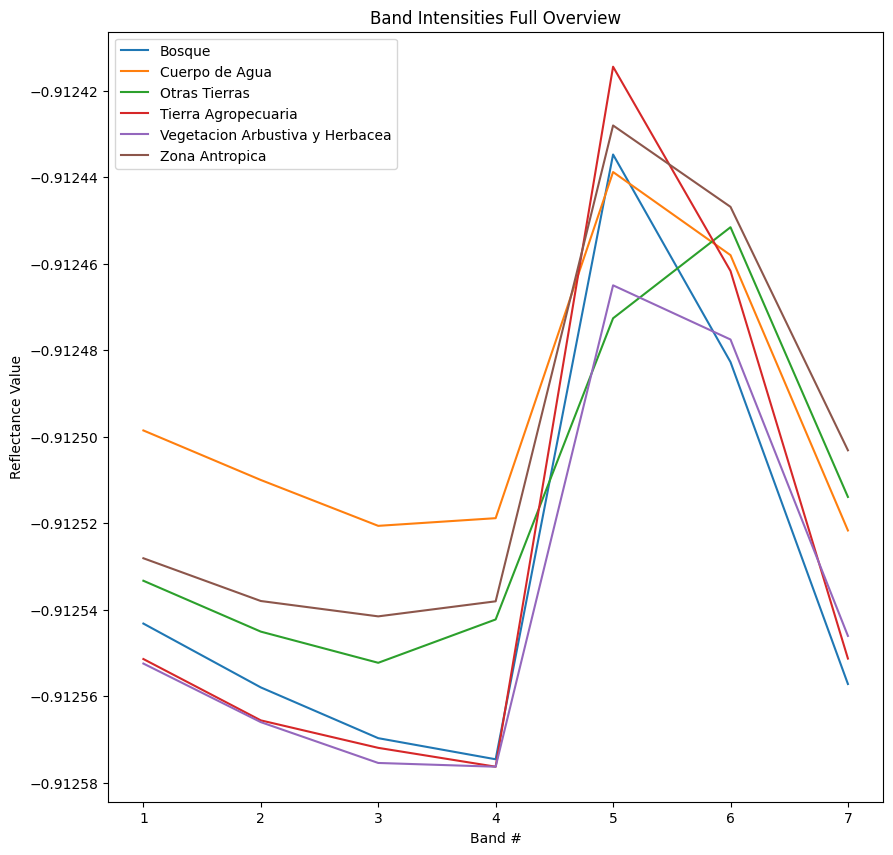

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# numbers 1-8
band_count = np.arange(1, 8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a titleA
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

#

In [ ]:
from keras.models import Sequential
from keras.layers import (
    Bidirectional,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    LSTM,
    MaxPooling2D,
    Reshape,
    BatchNormalization,
    Activation,
)
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay

## Establecer los hiperparámetros

In [ ]:
epochs = 2
batch_size = 25
dropout_rate = 0.3
learning_rate = 0.001
num_classes = len(class_names)

# dimensiones de la imagen de entrada
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


## Arquitectura CNN

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Agregamos una capa de Reshape para convertir la salida en 3D
model.add(Reshape((1, 1024)))

# Agregamos dos capas Bidirectional LSTM
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Regularización L2 en capa densa
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Regularización L2 en capa densa
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(num_classes))
model.add(Activation('softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        2048      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 64)      

In [ ]:
"""dropout_rate = 0.1
l1 = tf.keras.regularizers.l1(0)

model = Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', activity_regularizer=l1))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(3200, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.0003), metrics=['accuracy'])
print("\nModel architecture:\n")
model.summary()"""

'dropout_rate = 0.1\nl1 = tf.keras.regularizers.l1(0)\n\nmodel = Sequential()\n\nmodel.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))\nmodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding=\'same\', activation=\'relu\', activity_regularizer=l1))\nmodel.add(Dropout(dropout_rate))\n\nmodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding=\'same\', activity_regularizer=l1, activation=\'relu\'))\nmodel.add(Dropout(dropout_rate))\n\nmodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding=\'same\',activity_regularizer=l1, activation=\'relu\'))\nmodel.add(Dropout(dropout_rate))\n\nmodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding=\'same\', activity_regularizer=l1, activation=\'relu\'))\nmodel.add(Dropout(dropout_rate))\n\nmodel.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding=\'same\', activity_regularizer=l1, activation=\'relu\'))\nmodel.add(Dropout(dropout_rate))\n\nmodel.add(Flatten())\nmodel.add(Dense(3200, activatio

## Divida los datos en entrenamiento y validación

In [ ]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".format(n_training=len(train_px), n_val=len(val_px)))

# Training samples: 11995 
# Validation samples: 2999


In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
            print("\n Se ha alcanzado el umbral PRESICION. Entrenamiento detenido.....")
            self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [ ]:
tensorboard = TensorBoard(log_dir='logs/cnn')

history = model.fit(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size, merge=True
    ),
    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
    validation_data=tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True),
    validation_steps=len(val_px) // batch_size,
    callbacks=[early_stopping, tensorboard]
)

Epoch 1/2
479/479 [==============================] - 442s 915ms/step - loss: 4.8146 - accuracy: 0.2119 - val_loss: 2.4397 - val_accuracy: 0.1929
Epoch 2/2
479/479 [==============================] - 438s 914ms/step - loss: 2.1978 - accuracy: 0.2247 - val_loss: 1.9933 - val_accuracy: 0.1919


## Visualización de las curvas de entrenamiento y validación

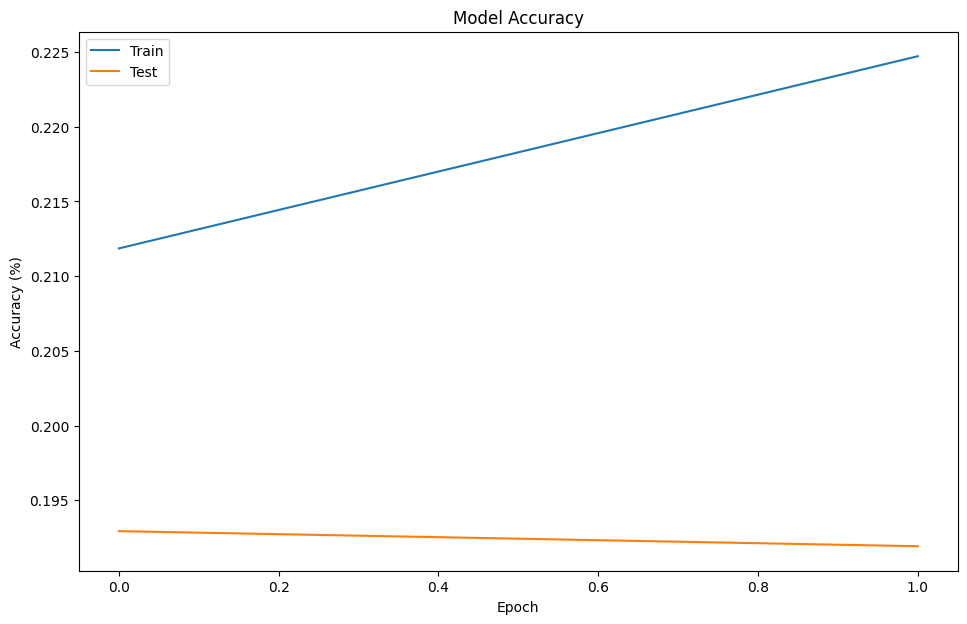

In [ ]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Test'], loc='upper left')

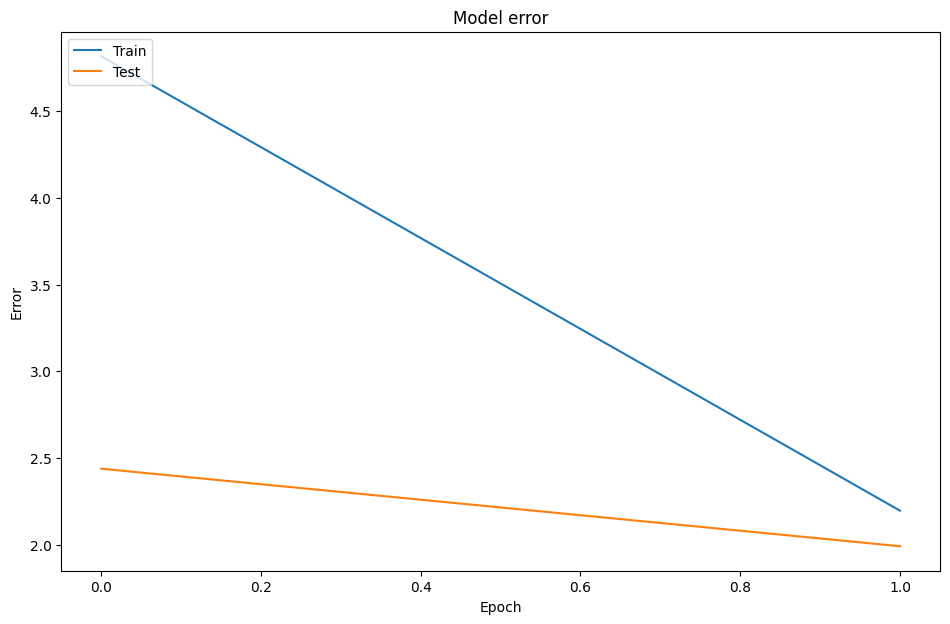

In [ ]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model error")
plt.ylabel("Error")
plt.xlabel("Epoch")
_ = plt.legend(['Train', 'Test'], loc='upper left')

# Guardar el modelo entrenado

In [ ]:
save_path = './models/'
model.save(f"{save_path}model_l8_s2_v2.h5")
print("Saved model to disk")

Saved model to disk


## Compruebe la precisión de las pruebas basándose en una matriz de confusión:

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True
    ),
    steps=len(val_px) // batch_size,
    verbose=1
)

119/119 [==============================] - 86s 721ms/step


In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    val_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

### Trazar matriz de confusión no normalizada

In [ ]:
plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

NameError: name 'plot_confusion_matrix' is not defined

### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

# Comprobación de la precisión del entrenamiento basándote en una matriz de confusión

¿Cómo de bien predice el modelo los datos de entrenamiento?

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size,
        merge=True
    ),
    steps=len(train_px) // batch_size,
    verbose=1
)

In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    train_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

### Trazar matriz de confusión no normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

In [ ]:
print("IPython Notebook execution completed!")